<a href="https://colab.research.google.com/github/tienenkuo/Multiple-Arm-Bandits-Algorithm/blob/main/Multiple_Arm_Bandits_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.stats import norm, beta, bernoulli
import matplotlib.pyplot as plt
import seaborn as sns

In this exercise we will implement three different algorithms for the multi-armed bandit problem and simulate their performance.


1.  Uniform Sampling - in each round we play a random arm.
2.  Epsilon-Greedy - 95% of the time we play the highest mean arm so far. Start it off by pulling each arm once.
3.  Thompson Sampling - main posterior distributions on each arm, take a sample from each posterior in each round, and then play the best arm.

Each method will expect two inputs:
1.   `means`: An array $[p_1, p_2, \cdots, p_n]$ of the mean clickthrough rates of each arm. So for example [.3, .25, .1] means we have 4 arms with the first arm have a .3 probability of a head, the second arm a .1 probability of a head, etc. We will experiment with different means. Of course in real life we don't know these values, but in our simulations we can see the performance of the algorithms on various sets of means.
2. `T`: The number of rounds you want the game to run for. We will experiment with different times.
In addition each method will keep track of some additional pieces of information relevant to the method.


In each method we will main several pieces of information:

1.   `total_reward`: The total amount of wins over each arm that we have obtained so far.
2.   `total_reward_history`: Once the game is over, we want to be able to plot how much reward we have obtained at each time. This allows us to compare the different algorithms at different times. 
3. `wins`: An array whose length is the same as the number of arms. It maintains the number of wins of each arm.
4. `losses`: An array whose length is the same as the number of arms. It maintains the number of losses on each arm.
5. `pulls`: An array whose length is the same as the number of arms. It maintains the number of pulls of each arm at each time.

The outputs are `total_reward_history` and `num_pulls`. After each method, I have given you functions to plot `total_reward_history` and `num_pulls` along with a cell at the end of the notebook that plots the outputs from all three methods so you can compare. 




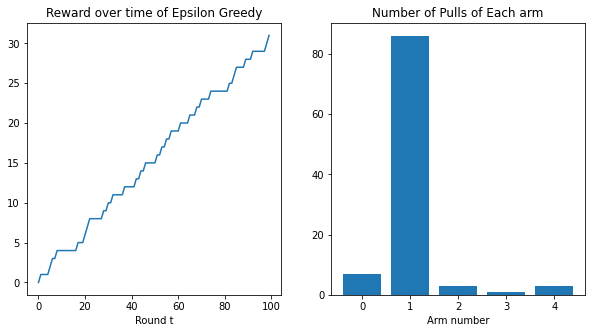

In [ ]:
def EpsilonGreedySimulation(means, T, epsilon=.95):
    num_arms = len(means)
    total_reward = 0 # Our total reward at each time
    total_reward_history = [] # Array that maintains a history of rewards at each time
    wins = np.zeros(num_arms) #Array to main the number of wins of each arm
    losses = np.zeros(num_arms) # Array to maintain the number of losses of each arm
    pulls = np.zeros(num_arms) # Array to maintain the number of pulls of each arm
    

    emp_means = [] # Array to main the empirical means (ie the running average) of the proportion of wins of each arm

    # Pull each arm once
    for i in range(num_arms):
        It = i
        # Get a reward from the i-th arm
        r = bernoulli(means[It]).rvs()
        if r==1:
            # If the reward is 1, update the number of wins
            wins[i] += 1
            
        else:
            # If the reward is 0, update the number of losses
            losses[i] += 1
        # Update the number of pulls
        pulls[i] += 1
        emp_means.append(r/pulls[i])
        total_reward += r
        total_reward_history.append(total_reward)
        

    for t in range(T-num_arms):
        if np.random.rand() < epsilon:
            #95% of the time we play the highest empirical mean
            It = np.argmax(emp_means)
        else:
            #5% of the time we play a random arm
            It = np.random.choice(num_arms)
        rt = bernoulli(means[It]).rvs() # Get a reward from this arm when we play it.
        total_reward += rt # update the total amount of reward we have at each time.
        total_reward_history.append(total_reward)  
        if rt == 1:
            wins[It] += 1
        else:
            losses[It] += 1 
        pulls[It] += 1 # Update the number of pulls of the arm we pulled
        emp_means[It] = wins[It]/pulls[It]
    return total_reward_history, pulls
# Test your function
means = [.3, .25, .1, .05, .01]
total_reward_history, pulls = EpsilonGreedySimulation(means, 100)
# Plot the total_reward_history and num pulls. To plot these next to each other, 
# I am using plt.subplots.
fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].plot(total_reward_history)
ax[0].set_title('Reward over time of Epsilon Greedy')
ax[0].set_xlabel('Round t')
ax[1].bar(range(len(means)), pulls)
ax[1].set_title('Number of Pulls of Each arm')
ax[1].set_xlabel('Arm number')
plt.show()

### Part 1
Now we implement the Uniform sampling algorithm. In each round choose a random arm.

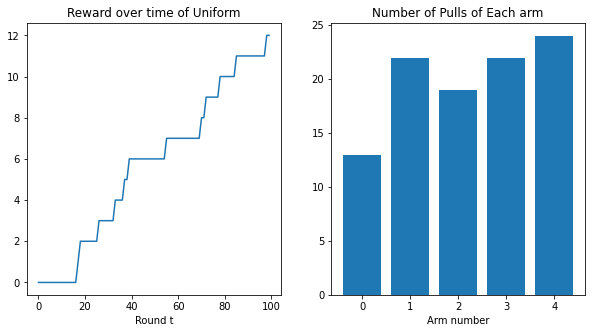

In [ ]:
def UniformSimulation(means, T):
    num_arms = len(means)
    total_reward = 0
    total_reward_history = []
    wins = np.zeros(num_arms)
    losses = np.zeros(num_arms)
    pulls = np.zeros(num_arms)
    
    for i in range(num_arms): # Pull each arm once to start the game
        It = i
        r = bernoulli(means[It]).rvs()
        if r == 1:
            wins[It] += 1
        else:
            losses[It] += 1
        total_reward += r
        total_reward_history.append(total_reward)
        pulls[i] += 1

    # Now we enter the main part of the game
    for t in range(T-num_arms):
        It = np.random.choice(num_arms)#Pick an arm at random 
        rt = bernoulli(means[It]).rvs()#Get a reward from that arm
        if rt==1:
            #Update the number of wins
            wins[It]+=1
        else:
            #Update the number of losses
            losses[It]+=1
        total_reward += rt # Update the total_reward
        total_reward_history.append(total_reward)
        pulls[It] += 1#Update the number of pulls on arm It
    return total_reward_history, pulls

# Test your function
means = [.3, .25, .1, .05, .01]
total_reward_history, pulls = UniformSimulation(means, 100)
fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].plot(total_reward_history)
ax[0].set_title('Reward over time of Uniform')
ax[0].set_xlabel('Round t')
ax[1].bar(range(len(means)), pulls)
ax[1].set_title('Number of Pulls of Each arm')
ax[1].set_xlabel('Arm number')
plt.show()

### Part 2
Now the big Kahuna. Implement Thompson Sampling below!

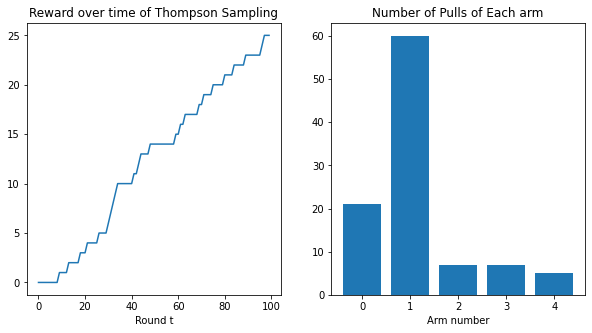

In [ ]:
def ThompsonSamplingSimulation(means, T):
    num_arms = len(means)
    total_reward = 0
    total_reward_history = []
    wins = np.zeros(num_arms)
    losses = np.zeros(num_arms)
    pulls = np.zeros(num_arms)
    
    posteriors = [] # Array to main the posterior beta distribution on each arm
    for i in range(num_arms): # Pull each arm once to start the game
        It = i
        r = bernoulli(means[It]).rvs()
        if r == 1:
            wins[It] += 1
        else:
            losses[It] += 1
        # add the beta posterior to our list of posteriors, we add 1 to make the beta distribution defined
        # posteriors being the values on the beta distributions?
        posteriors.append(beta(wins[It]+1, losses[It]+1)) 
        total_reward += r
        total_reward_history.append(total_reward)
        pulls[i] += 1

    for t in range(T-num_arms):
      draws = []
      for z in range(len(posteriors)):
        draws.append(posteriors[z].rvs())#Draw a q from each posterior
      It = np.argmax(draws) #Figure out what arm had the highest q and play it (see np.argmax)
        #Draw a random reward from It, update wt, and lt
      rt = bernoulli(means[It]).rvs()#Get a reward from that arm
      if rt==1:
            wins[It]+=1
      else:
            losses[It]+=1
      posteriors[It] = beta(wins[It]+1, losses[It]+1) #Updates the posterior on It
        #Update total_reward, total_reward_history, and the number of pulls on It. 
      total_reward += rt
      total_reward_history.append(total_reward)
      pulls[It] += 1
    return total_reward_history, pulls

# Test your function
means = [.3, .25, .1, .05, .01]
total_reward_history, pulls = ThompsonSamplingSimulation(means, 100)
fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].plot(total_reward_history)
ax[0].set_title('Reward over time of Thompson Sampling')
ax[0].set_xlabel('Round t')
ax[1].bar(range(len(means)), pulls)
ax[1].set_title('Number of Pulls of Each arm')
ax[1].set_xlabel('Arm number')
plt.show()

Now we are going to run each and at each time-step plot the cumulative reward over 1000 runs, comparing the performance of the different bandit methods.

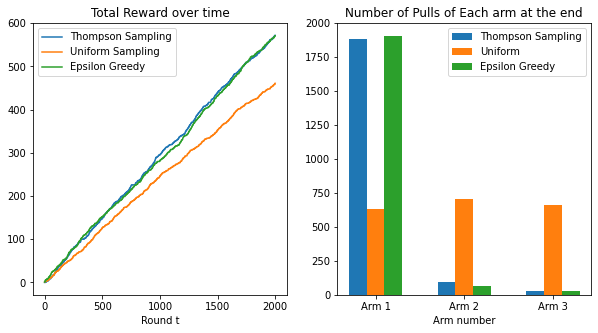

In [ ]:
means = [.3, .25, .1]
T = 2000 # if your code breaks, or you want to debug, turn this value down to 100 and it will run faster
history_TS, pulls_TS = ThompsonSamplingSimulation(means, T)
history_UN, pulls_UN = UniformSimulation(means, T)
history_EG, pulls_EG = EpsilonGreedySimulation(means, T)

fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].plot(history_TS, label='Thompson Sampling')
ax[0].plot(history_UN, label='Uniform Sampling')
ax[0].plot(history_EG, label='Epsilon Greedy')
ax[0].set_title('Total Reward over time')
ax[0].set_xlabel('Round t')
ax[0].legend()
x = np.arange(1,len(means)+1)
ax[1].bar(x, pulls_TS, width=0.2, label='Thompson Sampling')
ax[1].bar(x+.2, pulls_UN, width=0.2, label='Uniform')
ax[1].bar(x+.4,pulls_EG, width=0.2, label='Epsilon Greedy')
ax[1].set_title('Number of Pulls of Each arm at the end')
ax[1].set_xlabel('Arm number')
ax[1].set_xticks(x+.2)
ax[1].set_xticklabels( ['Arm {}'.format(i) for i in x] )
ax[1].legend()
plt.show()

###Part 3
Make a copy of the previous cell and run on the following mean inputs

1. [.1, .01, .01, .01], for T=5000 timesteps
2. [.06, .06, .07, .08], for T=5000 timesteps.
3. Try 5 arms

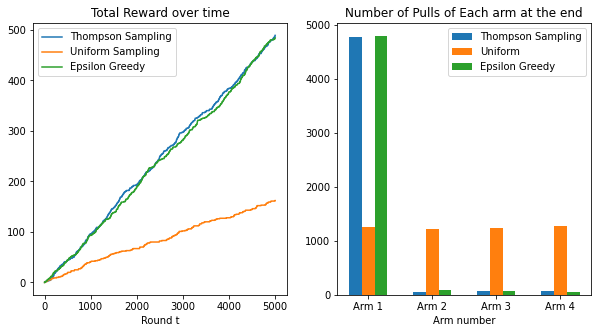

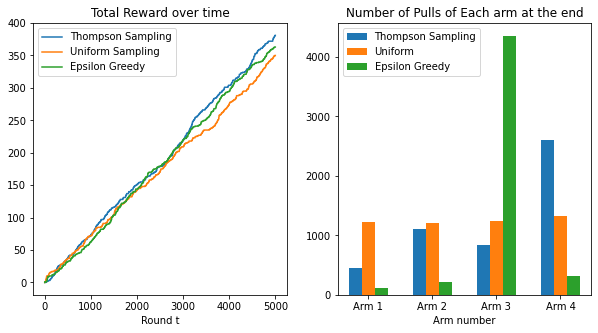

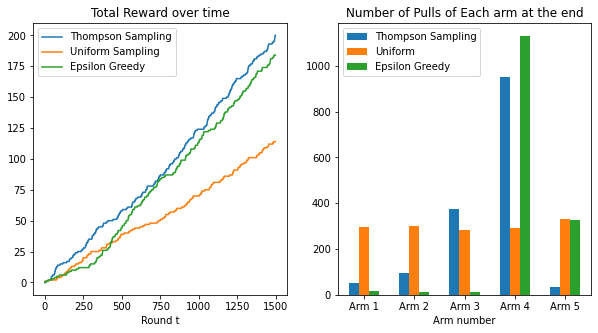

In [ ]:

def output(means,T):
  history_TS, pulls_TS = ThompsonSamplingSimulation(means, T)
  history_UN, pulls_UN = UniformSimulation(means, T)
  history_EG, pulls_EG = EpsilonGreedySimulation(means, T)

  fig, ax = plt.subplots(1, 2, figsize = (10,5))
  ax[0].plot(history_TS, label='Thompson Sampling')
  ax[0].plot(history_UN, label='Uniform Sampling')
  ax[0].plot(history_EG, label='Epsilon Greedy')
  ax[0].set_title('Total Reward over time')
  ax[0].set_xlabel('Round t')
  ax[0].legend()
  x = np.arange(1,len(means)+1)
  ax[1].bar(x, pulls_TS, width=0.2, label='Thompson Sampling')
  ax[1].bar(x+.2, pulls_UN, width=0.2, label='Uniform')
  ax[1].bar(x+.4,pulls_EG, width=0.2, label='Epsilon Greedy')
  ax[1].set_title('Number of Pulls of Each arm at the end')
  ax[1].set_xlabel('Arm number')
  ax[1].set_xticks(x+.2)
  ax[1].set_xticklabels( ['Arm {}'.format(i) for i in x] )
  ax[1].legend()
  plt.show()

#1

output([.1, .01, .01, .01],5000)

#2
output([.06, .06, .07, .08],5000)

#3
output([.02, .03, .1, .15, .05],1500)

**Findings**

**1. Looking at the charts above, it is clear that the two algorithms of Thompson Sampling and Epsilon Greedy is much better for wins than uniform sampling, which would be drawing arms at equal frequencies. As for what real-life settings could the above mean parameters correspond to, these could be outputs from any type of observational experiment that a business needs to make a decision on**



**2. The simulations expose which algorithms do best under different sets of circumstances. When there are potential outliers, we see that Thompson sampling and Epsilon Greedy algorithms return similar amount of wins / success, with uniform the least desirable. When there are similar values that the algorithms need to evaluate, they seem to perform relatively equally. In situations where there is a wide range of data, it is clear that Thompson and Epsilon methods perform better, gathering more wins. It would be critical for a business to understand the strengths and weaknesses of the methods that they are applying. They would need a good understanding of their data and determine how flexible they want their algorithm to be as more data comes into their system. It is also critical that they choose the method that will maximize the wins such that the project returns the max ROI without losing out on the revenues that exploration would offer.**